# U-Net for Image Segmentation
dataset url: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/ESWu7tAMzlFMnraBhlX29IUBrBQzCyQtJOEOjEcqoFvn8g?e=whclvZ

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from PIL import Image
from glob import glob

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

In [2]:
#Settings and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

bs_train, bs_test = 4, 1
epochs = 100
lr = 0.0001

cuda


In [3]:
# get ds list

#Create lists for the paths of training images and training masks 
img_files = []
mask_files = glob('C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/brain_mri/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    img_files.append(i.replace('_mask',''))

print(mask_files[0])
print(img_files[0])

C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/brain_mri/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif
C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/brain_mri/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif


In [4]:
# load image function
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        if np.array(img).ndim != 3:
            return img.convert('L')
        else:
            return img.convert('RGB')

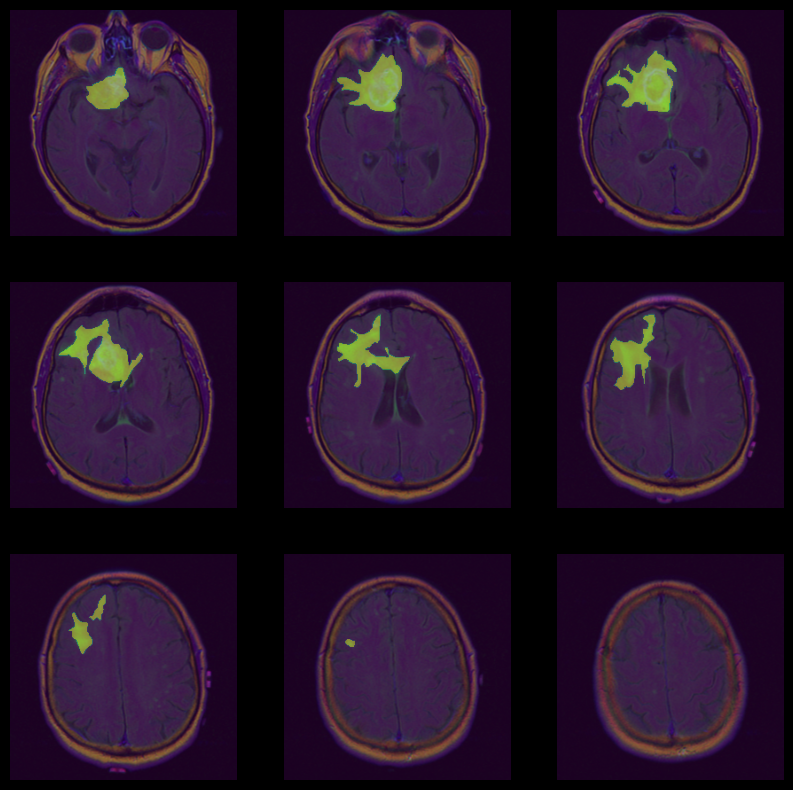

In [5]:
#Display some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=img_files[i]
    msk_path=mask_files[i]
    img=pil_loader(img_path)
    msk=pil_loader(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
    plt.axis('off')
plt.show()

In [6]:
# split dataset in train and test
ds_split = len(img_files)//10

img_files_train, mask_files_train = img_files[ds_split:], mask_files[ds_split:]
img_files_test, mask_files_test = img_files[:ds_split], mask_files[:ds_split]

print(len(img_files_train), len(img_files_test))

3537 392


In [7]:
#Create a custom dataset class which applies identical transformations to the training and test data
# In this case we will define transforms directly into the get_item function
class MRIDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping (we apply transforms here because we need to apply 
        # them with the same probability to both img and mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

We will use the Dice loss (smoothed).

Alternative: Binary Cross Entropy or L1 Loss (try it as an exercise).

![alt text](https://i.sstatic.net/OsH4y.png)

In [8]:
#Define a dice loss function
def dc_loss(pred, target):
    smooth = 1.

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (predf.sum() + targetf.sum() + smooth))

### U-Net

![alt text](https://www.researchgate.net/publication/331406702/figure/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png)

In [9]:
#Define the UNet architecture


def conv_layer(input_channels, output_channels):     #This is a helper function to create the convolutional blocks
    conv = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )
    return conv

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # input dim 256x256
        self.down_1 = conv_layer(3, 64) #128x128
        self.down_2 = conv_layer(64, 128) #64x64
        self.down_3 = conv_layer(128, 256) #32x32
        self.down_4 = conv_layer(256, 512) #16x16
        self.down_5 = conv_layer(512, 1024) #8x8
        
        self.up_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_layer(1024, 512)
        self.up_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_layer(512, 256)
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_layer(256, 128)
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_layer(128, 64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)
        self.output_activation = nn.Sigmoid()
                
    def forward(self, img):     #The print statements can be used to visualize the input and output sizes for debugging
        x1 = self.down_1(img) #256x256
        #print(x1.size())
        x2 = self.max_pool(x1)
        #print(x2.size())
        x3 = self.down_2(x2)
        #print(x3.size())
        x4 = self.max_pool(x3)
        #print(x4.size())
        x5 = self.down_3(x4)
        #print(x5.size())
        x6 = self.max_pool(x5)
        #print(x6.size())
        x7 = self.down_4(x6)
        #print(x7.size())
        x8 = self.max_pool(x7) #8x8
        #print(x8.size())
        x9 = self.down_5(x8)
        #print(x9.size())
        
        x = self.up_1(x9) # x.size() = bs, 512, h, w x7.size() = bs, 512, h, w #16x16
        #print(x.size())
        x = self.up_conv_1(torch.cat([x, x7], 1)) # torch.cat([x, x7], 1).size() = bs, 1024, h, w
        #print(x.size())
        x = self.up_2(x)
        #print(x.size())
        x = self.up_conv_2(torch.cat([x, x5], 1)) 
        #print(x.size())
        x = self.up_3(x)
        #print(x.size())
        x = self.up_conv_3(torch.cat([x, x3], 1))
        #print(x.size())
        x = self.up_4(x)
        #print(x.size())
        x = self.up_conv_4(torch.cat([x, x1], 1)) #256x256
        #print(x.size())
        
        x = self.output(x)
        x = self.output_activation(x)
        #print(x.size())
        
        return x
        

In [10]:
#Datasets
train_dataset = MRIDataset(img_files_train, mask_files_train)
test_dataset = MRIDataset(img_files_test, mask_files_test)

#Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs_test, shuffle=True)

In [11]:
#Initialize the model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))

In [12]:
#define path where to save the model
PATH = './res/unet_test.pth'

In [13]:
from tqdm import tqdm

#Training function 
def train(model, epochs):
    
    #Keep track of average training and test losses for each epoch
    avg_train_losses = []
    avg_test_losses = []
    
    #Trigger for earlystopping
    earlystopping = False 

    #Training loop
    for epoch in range(epochs):
        
        #Record the training and test losses for each batch in this epoch
        train_losses = []
        test_losses = []

        model.train()

        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (images, targets) in loop:
            
            images = images.to(device)
            targets = targets.to(device) # the ground truth mask

            model.zero_grad()
            pred = model(images)
            loss = dc_loss(pred, targets) #or L1 or BCE
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
                        
            with torch.no_grad():     #Show some samples at the first batch of each epoch 
                if batch == 1:
                    #torch.save(model.state_dict(), PATH)

                    model.eval()

                    (img, mask) = next(iter(test_dataloader))
                    img = img.to(device)
                    mask = mask.to(device)
                    mask = mask[0]
                    pred = model(img)

                    plt.figure(figsize=(12,12))
                    plt.subplot(1,3,1)
                    plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
                    plt.title('Original Image')
                    plt.subplot(1,3,2)
                    plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2))
                    plt.title('Original Mask')
                    plt.subplot(1,3,3)
                    plt.imshow(np.squeeze(pred.cpu()) > .5)
                    plt.title('Prediction')
                    plt.show()

                    model.train()

                
        model.eval()
        
        with torch.no_grad():     #Record and print average validation loss for each epoch 
            for test_batch, (test_images, test_targets) in enumerate(test_dataloader):
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)
                test_pred = model(test_images.detach())

                test_loss = dc_loss(test_pred, test_targets).item()

                test_losses.append(test_loss)

            epoch_avg_train_loss = np.mean(train_losses)
            epoch_avg_test_loss = np.mean(test_losses)
            avg_train_losses.append(epoch_avg_train_loss)
            avg_test_losses.append(epoch_avg_test_loss)

            print_msg = (f'train_loss: {epoch_avg_train_loss:.5f} ' + f'valid_loss: {epoch_avg_test_loss:.5f}')

            print(print_msg)
        
        if epoch > 10:     #Early stopping with a patience of 1 and a minimum of 10 epochs 
            if avg_test_losses[-1]<=avg_test_losses[-2]:
                print("Early Stopping Triggered With Patience 1")
                torch.save(model.state_dict(), PATH)
                earlystopping = True 
        if earlystopping:
            break

    return  model, avg_train_losses, avg_test_losses

  0%|                                                                                | 1/885 [00:05<1:18:06,  5.30s/it]

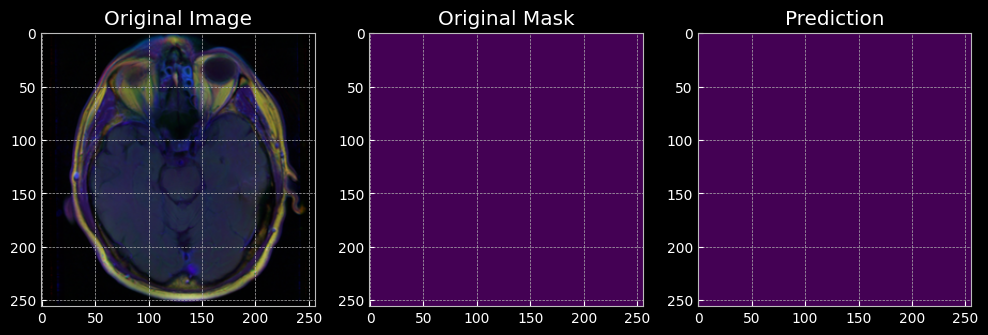

KeyboardInterrupt: 

In [14]:
#Train the model 
best_model, avg_train_losses, avg_val_losses = train(model, epochs)

In [15]:
#Load a set of weights
PATH = "./res/unet.pth"
model.load_state_dict(torch.load(PATH))

C:\Users\Tomaso Fontanini\AppData\Local\Temp\ipykernel_13332\2152658403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

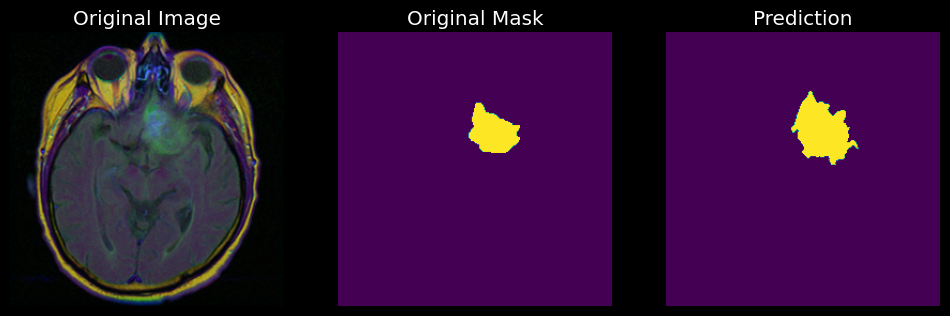

In [16]:
#Test the model with some samples from the test dataset 
model.eval()

(img, mask) = test_dataset[1] #next(iter(test_dataloader))
img = img.unsqueeze(0)
mask = mask.unsqueeze(0)
img = img.to(device)
mask = mask.to(device)
mask = mask[0]
pred = model(img)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2))
plt.title('Original Mask')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred.cpu()) > .5)
plt.title('Prediction')
plt.axis('off')
plt.show()

In [ ]:
# Calculate the UNET training accuracy

Model can be found here: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/ERufamtghHBLu5MtFfd_YZ4ByBU10-QNmdLRiAYhWP3EPA?e=kpLMV5